### To identify the top-rated movies from the dataset of the past 20 years

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("TopRatedMovies").getOrCreate()
df = spark.read.csv("cleaned_data96-22.csv", header=True, inferSchema=True)


In [3]:
from pyspark.sql.functions import year, current_date
df_filtered = df.filter(year(current_date()) - df.Year <= 20)
from pyspark.sql.functions import desc
df_sorted = df_filtered.sort(desc("Rating"))
top_movies = df_sorted.select("Rank", "Title", "Year", "Rating", "Votes")
top_movies.show()

+----+--------------------+----+------+-------+
|Rank|               Title|Year|Rating|  Votes|
+----+--------------------+----+------+-------+
|   1|               Daman|2022|   9.1|  13172|
|   1|     The Dark Knight|2008|   9.0|2699979|
|   1|The Lord of the R...|2003|   9.0|1876007|
|   1|         Mirror Game|2016|   9.0|  27434|
|   2|         The Unnamed|2016|   9.0|   5423|
|   1|Demon Slayer: Kim...|2021|   8.9|  17369|
|   1|Kill Bill: The Wh...|2006|   8.8|  13732|
|   1|   C/o Kancharapalem|2018|   8.8|   7405|
|   2|Les Misérables in...|2010|   8.8|   6207|
|   1|Demon Slayer: Kim...|2020|   8.8|  13003|
|   2|            Jai Bhim|2021|   8.8| 205641|
|   2|         777 Charlie|2022|   8.8|  34244|
|   4|Rocketry: The Nam...|2022|   8.8|  52647|
|   1|The Phantom of th...|2011|   8.8|   9464|
|   1|           Inception|2010|   8.8|2396317|
|   3|               #Home|2021|   8.8|  13931|
|   3|The Legend of Mau...|2022|   8.8|   9868|
|   5|           Aparajito|2022|   8.8| 

### To analyze the trends in movie ratings over time and gain insights into the factors that affect them:


In [6]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MovieRatingsTrend").getOrCreate()
df = spark.read.csv("cleaned_data96-22.csv", header=True, inferSchema=True)

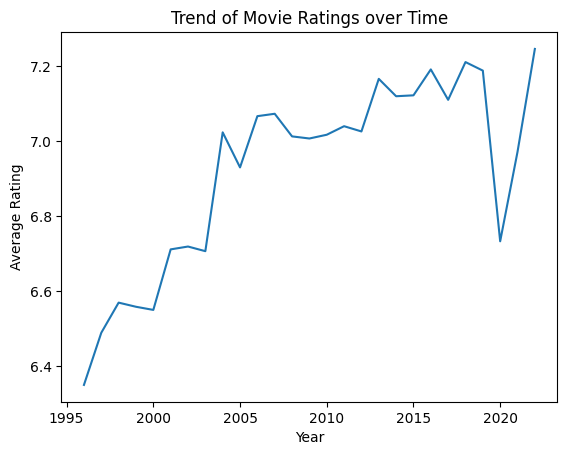

In [7]:
from pyspark.sql.functions import to_date, year
df_ratings = df.select("Rating", to_date("Year", "yyyy").alias("ReleaseDate"))
avg_ratings = df_ratings.groupBy(year("ReleaseDate").alias("Year")).avg("Rating").orderBy("Year")
import matplotlib.pyplot as plt

# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
avg_ratings_pd = avg_ratings.toPandas()

# Plot the trend of movie ratings over time
plt.plot(avg_ratings_pd["Year"], avg_ratings_pd["avg(Rating)"])
plt.title("Trend of Movie Ratings over Time")
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.show()


### To determine the most popular movie genres in the past 20 years
### by analyzing the dataset:

In [16]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("PopularGenres").getOrCreate()
df = spark.read.csv("cleaned_data96-22.csv", header=True, inferSchema=True)

from pyspark.sql.functions import array, coalesce, explode

# Create a new DataFrame with movies from the last 20 years
df_filtered = df.filter(year(current_date()) - df.Year <= 20)

# Combine the three genre columns into a single column, and explode the values
df_genres = df_filtered.select(explode(array(
    coalesce(col("Genre1"), col("Genre2"), col("Genre3"))
)).alias("Genre"))

# Count the frequency of each genre and display the top 10
genre_counts = df_genres.groupBy("Genre").count().orderBy("count", ascending=False)
top_genres = genre_counts.limit(10)

# Show the results
top_genres.show()



+---------+-----+
|    Genre|count|
+---------+-----+
|    Drama| 1237|
|   Comedy| 1124|
|   Action| 1058|
|Biography|  449|
|    Crime|  399|
|Animation|  304|
|Adventure|  221|
|   Horror|   93|
|  Mystery|   21|
|  Fantasy|    9|
+---------+-----+



### To analyze the relationship gross revenue to understand the factors that impact profitability:

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, avg, regexp_replace


spark = SparkSession.builder.appName("GrossRevenueAnalysis").getOrCreate()


df = spark.read.option("header", True).csv("top_250movies_96_22.csv")


gross_df = df.select("IMDByear", "Gross")


gross_df = gross_df.filter(col("Gross") != "")


gross_df = gross_df.withColumn("Gross", regexp_replace(col("Gross"), "[^\d\.]", "").cast("double"))


gross_summary_df = gross_df.groupBy("IMDByear").agg(sum("Gross"), avg("Gross"))


gross_summary_df = gross_summary_df.orderBy("IMDByear")


gross_summary_df.show()


+--------+------------------+------------------+
|IMDByear|        sum(Gross)|        avg(Gross)|
+--------+------------------+------------------+
|    1996| 5587.250000000002| 27.93625000000001|
|    1997|           6382.03| 32.23247474747475|
|    1998| 6138.110000000001|31.000555555555557|
|    1999| 7209.830000000001| 34.33252380952381|
|    2000| 7185.250000000006|33.733568075117404|
|    2001| 7356.310000000003|35.366875000000014|
|    2002| 7898.160000000001|38.716470588235296|
|    2003| 7890.329999999996| 38.30257281553396|
|    2004| 7224.569999999999|38.634064171122986|
|    2005| 6268.990000000001|32.821937172774874|
|    2006| 6069.290000000003| 30.80857868020306|
|    2007|6161.7699999999995|  33.4878804347826|
|    2008| 6402.510000000002| 34.23802139037434|
|    2009| 6570.599999999998|35.904918032786874|
|    2010| 6498.070000000001| 37.34522988505748|
|    2011| 6107.400000000009| 33.19239130434787|
|    2012| 7902.340000000005|  45.1562285714286|
|    2013| 7685.6300

### Filter the dataset to include only movies released in the last 20 years.
### Extract the top actors and directors from the "cast" and "director" columns.
### Calculate the frequency of each actor and director.
### Plot a bar chart to visualize the most successful actors and directors.

+------------------+-----+
|             Actor|count|
+------------------+-----+
|     Ryan Reynolds|   32|
|  Amitabh Bachchan|   29|
|    Cate Blanchett|   28|
|     Colin Farrell|   28|
|        Matt Damon|   27|
|      Mark Ruffalo|   27|
|   Jake Gyllenhaal|   27|
|       Naomi Watts|   26|
|      Akshay Kumar|   26|
|Scarlett Johansson|   25|
|         Tom Hanks|   25|
| Samuel L. Jackson|   24|
| Robert Downey Jr.|   24|
|   Woody Harrelson|   24|
|       Prakash Raj|   23|
|      Steve Carell|   23|
|      Willem Dafoe|   23|
|      Meryl Streep|   23|
|    Christian Bale|   23|
| Denzel Washington|   22|
+------------------+-----+
only showing top 20 rows

+------------------+-----+
|          Director|count|
+------------------+-----+
|       Woody Allen|   17|
|    Clint Eastwood|   15|
|  Steven Spielberg|   14|
| Steven Soderbergh|   13|
|      Ridley Scott|   12|
| Richard Linklater|   12|
| Kore-eda Hirokazu|   11|
|     François Ozon|   11|
|     Antoine Fuqua|   10|
| 

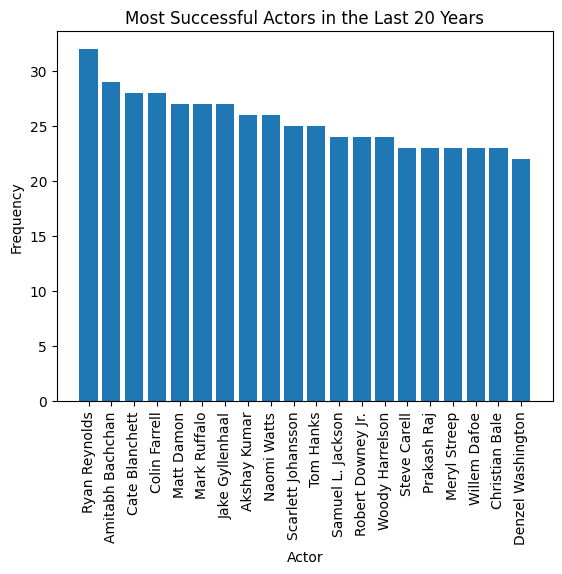

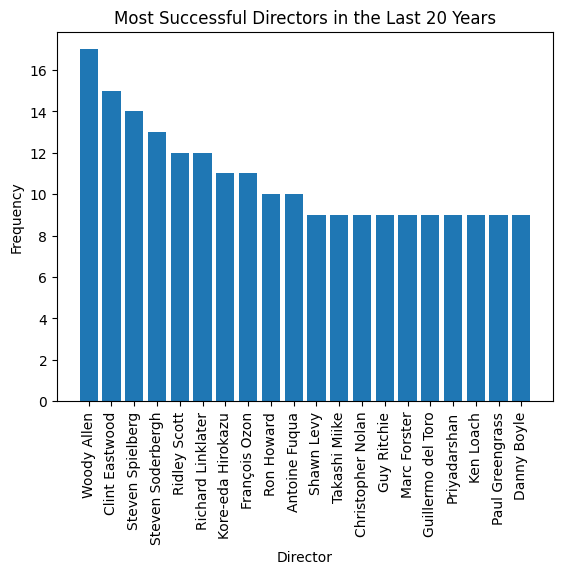

In [11]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col


spark = SparkSession.builder.appName("TopActorsDirectorsAnalysis").getOrCreate()


df = spark.read.option("header", True).csv("cleaned_data96-22.csv")


df = df.filter(col("Year") >= 2002)


df.createOrReplaceTempView("movies")

# extract the top actors and directors from the "cast" and "director" columns using SQL queries
actors_df = spark.sql("""
    SELECT explode(split(concat_ws(",", Actor1, Actor2, Actor3, Actor4), ",")) AS Actor
    FROM movies
    WHERE Actor1 IS NOT NULL AND Actor2 IS NOT NULL AND Actor3 IS NOT NULL AND Actor4 IS NOT NULL
""")
directors_df = spark.sql("""
    SELECT explode(split(Director, ",")) AS Director
    FROM movies
    WHERE Director IS NOT NULL
""")


actors_freq_df = actors_df.groupBy("Actor").count().orderBy(col("count").desc())
directors_freq_df = directors_df.groupBy("Director").count().orderBy(col("count").desc())


actors_freq_df.show()
directors_freq_df.show()

import matplotlib.pyplot as plt


def plot_bar_chart(df, title):
    # convert the DataFrame to a Pandas DataFrame
    pdf = df.toPandas()

    plt.bar(pdf.iloc[:,0], pdf.iloc[:,1])

   
    plt.title(title)
    plt.xlabel(df.columns[0])
    plt.ylabel("Frequency")

    # rotate the x-axis labels for better visibility
    plt.xticks(rotation=90)

   
    plt.show()


plot_bar_chart(actors_freq_df.limit(20), "Most Successful Actors in the Last 20 Years")
plot_bar_chart(directors_freq_df.limit(20), "Most Successful Directors in the Last 20 Years")


### Analyze the distribution of movie durations in the dataset and identify any trends or patterns.

+----+------------------+-----------------+
|Year|       AvgDuration|         AvgVotes|
+----+------------------+-----------------+
|1996|108.19909502262443|53862.85520361991|
|1997|110.23684210526316|77462.10964912281|
|1998| 108.9650655021834|77551.35371179039|
|1999|            111.46|        91755.568|
|2000|           108.544|        81110.752|
|2001|            111.08|        95221.392|
|2002|           107.752|        93012.056|
|2003|           110.424|        96776.968|
|2004|           113.064|        107632.38|
|2005|            113.14|        90119.116|
|2006|           113.652|        99495.928|
|2007|            112.44|       103741.248|
|2008|           113.496|       107698.424|
|2009|           112.416|       102911.888|
|2010|           111.644|       109995.856|
|2011|             111.9|       111145.888|
|2012|           112.936|        116826.94|
|2013|           113.992|       121221.228|
|2014|           115.316|        121749.48|
|2015|           115.816|       

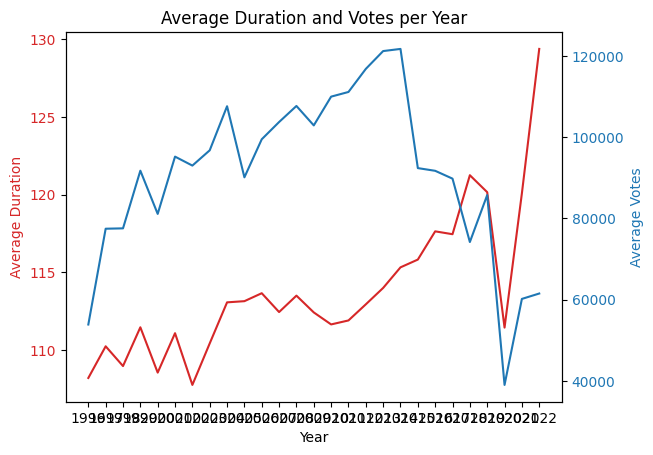

In [27]:
from pyspark.sql import SparkSession


spark = SparkSession.builder.appName("DurationYearVotesAnalysis").getOrCreate()


df = spark.read.option("header", True).csv("cleaned_data96-22.csv")


df = df.filter((df.Year >= 1996) & (df.Year <= 2022))


df = df.select("Year", "Duration", "Votes")


df.createOrReplaceTempView("movies")


query = """
    SELECT Year, AVG(Duration) AS AvgDuration, AVG(Votes) AS AvgVotes
    FROM movies
    GROUP BY Year
    ORDER BY Year
"""


spark.sql(query).show()


from pyspark.sql.functions import avg
import matplotlib.pyplot as plt


results_df = spark.sql(query).toPandas()


fig, ax1 = plt.subplots()


color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Duration', color=color)
ax1.plot(results_df['Year'], results_df['AvgDuration'], color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Average Votes', color=color)
ax2.plot(results_df['Year'], results_df['AvgVotes'], color=color)
ax2.tick_params(axis='y', labelcolor=color)


plt.xticks(rotation=45)


plt.title('Average Duration and Votes per Year')
plt.show()
